本文档承接idea继续进行研究工作：idea文档太长，效率下降

在添加新因子以后，需要更新以下部分
1. factor_calculator
2. factor_constructor
3. factor_initializer
4. factor_reader
5. factor_updater
6. factors_updater(factor_updater的对外接口)

In [1]:
'''
Description: 
Author: czl
Date: 2023-08-07 14:32:49
LastEditTime: 2023-08-08 11:11:23
LastEditors:  
'''
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import jqdatasdk as jqdata
from tqdm import tqdm
import sqlite3
from abc import abstractmethod
import datetime

In [2]:
from const import *   # import the const.
from classes.basic_calculator import STOCK_LIST, TRADE_DATE_LIST
from classes.basic_functions import DateCalculator, index_columns_check
from classes.data_downloader import DailyPriceDataDownloader, DailyValuationDataDownloader, DailyFinancialDataDownloader, CertainEquityDataDownloader
from classes.data_reader import DailyPriceDataReader, DailyValuationDataReader, DailyFinancialDataReader, CertainEquityDataReader, CrossPriceDataReader, CrossValuationDataReader, FactorsDataReader
from classes.factor_calcualtor import FscoreCalculator, ReversalFactorCalculator, ValuationFactorCalculator
from classes.factor_constructor import FscoreConstructor, FactorsInitializer

from classes.data_constructor import CrossDataInitializer
from classes.signal_generator import SignalGeneratorTemplate, DoubleGenerator
from classes.back_tester import BackTesterTemplate, SimpleBackTester, CompletedBackTester, get_IC
from classes.signal_transfer import SignalTransferTemplate, MonthlyLastSignalTransfer, WeeklyLastFactorTransfer
from classes.data_updater import data_updating
from classes.factor_updater import FactorsUpdater

auth success 


#### 交易信号频率转换：降低换仓频率
1. DateCalculator: 寻找开仓时间点：每月末、每周末等
2. SignalTransferTemplate: 将一段时间内的交易信号统一
   1. 统一方式：最新一天或者过去的均值（待测试）

SignalTransfer功能设计
1. find trading_date_list:找到调仓日期
2. 在持仓周期内统一信号

TESTING

In [3]:
factors_reader = FactorsDataReader()
df_reversal = factors_reader.get_reversals()

price_data_reader = CrossPriceDataReader()
df_open = price_data_reader.read_open()

In [ ]:
# df_reversal.index[0].weekday()

In [ ]:
signal_generator = SignalGeneratorTemplate()
df_signal = signal_generator.get_signal(df_factor=df_reversal)

signal_transfer = WeeklyLastFactorTransfer()
df_signal_week = signal_transfer.signal_transfering(df_signal=df_signal)

100%|██████████| 6/6 [01:16<00:00, 12.75s/it]


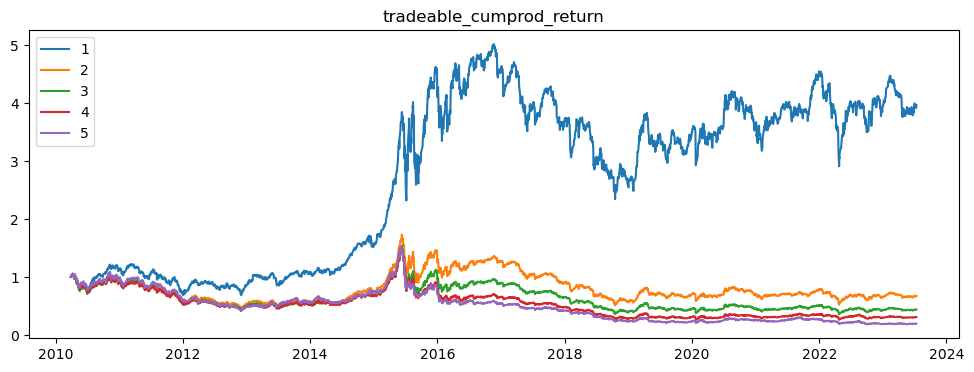

In [ ]:
back_tester = CompletedBackTester(open_df=df_open, singnal_df=df_signal_week)

back_tester.get_tradable_return_plot()

### updater
1. #### update 数据库
   1. 功能：
      1. 获取当日日期
      2. 读取原有数据：获取最后一天：从日度数据表获取
      3. 从数据源获取数据（datadownloader函数）:考虑当股票新出现的时候，需要下载所有数据
      4. 数据处理
      5. 存入数据库
   2. 注意事项
      1. 检查initialized数据是否含有12-31(包前包后问题)
2. #### 最新一天因子计算：
   1. 取最后两年的数据进行initializer
   2. 去最后一天的因子

update 数据库

In [ ]:
str(datetime.date.today())

'2023-08-09'

In [ ]:
daily_price_data_reader = DailyFinancialDataReader()

In [ ]:
stock = STOCK_LIST[1]
df_price = daily_price_data_reader.get_one_table(stock=stock)

In [ ]:
df_price.iloc[240:250]  # 存在31日

,open,close,high,low,volume,money
date,,,,,,
2010-12-30,616.39,612.48,617.56,606.22,456088.0,2.789792e+08
2010-12-31,612.87,617.17,620.29,609.35,616311.0,3.783178e+08
2011-01-04,618.34,626.16,632.41,611.70,918080.0,5.733437e+08
2011-01-05,624.99,622.64,630.46,621.86,607539.0,3.798691e+08
2011-01-06,622.64,617.95,628.50,613.65,528402.0,3.271489e+08
2011-01-07,617.56,641.40,655.86,613.65,1971249.0,1.263299e+09
2011-01-10,634.37,624.59,641.01,621.47,925836.0,5.841725e+08
2011-01-11,621.47,632.80,636.71,620.69,532673.0,3.352604e+08
2011-01-12,634.37,641.01,641.79,629.68,709035.0,4.512908e+08


In [ ]:
df_price.iloc[-5:]

,day,code,roa,net_operate_cash_flow,total_assets,operating_profit,total_non_current_liability,total_current_assets,total_current_liability,gross_profit_margin,operating_revenue
date,,,,,,,,,,,
2023-08-02,2023-08-02,000002.XSHE,0.16,7.001300e+09,1.743079e+12,4.091132e+09,2.857500e+11,1.401049e+12,1.059823e+12,15.45,6.847401e+10
2023-08-03,2023-08-03,000002.XSHE,0.16,7.001300e+09,1.743079e+12,4.091132e+09,2.857500e+11,1.401049e+12,1.059823e+12,15.45,6.847401e+10
2023-08-04,2023-08-04,000002.XSHE,0.16,7.001300e+09,1.743079e+12,4.091132e+09,2.857500e+11,1.401049e+12,1.059823e+12,15.45,6.847401e+10
2023-08-07,2023-08-07,000002.XSHE,0.16,7.001300e+09,1.743079e+12,4.091132e+09,2.857500e+11,1.401049e+12,1.059823e+12,15.45,6.847401e+10
2023-08-08,2023-08-08,000002.XSHE,0.16,7.001300e+09,1.743079e+12,4.091132e+09,2.857500e+11,1.401049e+12,1.059823e+12,15.45,6.847401e+10


In [3]:
data_updating()

start to update the daily financial data
the lastest stock list have 5015 stocks
the original stock list have 5015 stocks


100%|██████████| 5015/5015 [12:50<00:00,  6.51it/s]  


start to update the daily valuation data
the lastest stock list have 5015 stocks
the original stock list have 5015 stocks


100%|██████████| 5015/5015 [13:22<00:00,  6.25it/s]  


start to update the certain equity data


100%|██████████| 5015/5015 [23:47<00:00,  3.51it/s]  


In [8]:
# updated data check
def daily_database_check(data_reader, standard_len):
    """
    used to check the database
    1. print the number of stock 
    2. check whether all the table(daily data) have same rows
    """

    # get the len of stock_list
    stock_list = data_reader.get_all_stocks()
    print("the number of stocks is {}".format(len(stock_list)))

    # start to check the row number of everry stock
    print("follows are the stocks that the rows may be wrong")
    for stock in tqdm(stock_list):
        df_stock = data_reader.get_one_table(stock=stock)

        if df_stock.shape[0] != standard_len:
            print("the len of {} is {}".format(stock, df_stock.shape[0]))
        continue
    pass

In [9]:
daily_financial_reader = DailyFinancialDataReader()
daily_database_check(data_reader=daily_financial_reader, standard_len=3307)

the number of stocks is 5015
follows are the stocks that the rows may be wrong


  0%|          | 1/5015 [00:00<22:03,  3.79it/s]

the len of 000001.XSHE is 3306


  1%|▏         | 66/5015 [00:14<18:07,  4.55it/s]

the len of 000166.XSHE is 2018


  1%|▏         | 68/5015 [00:15<18:42,  4.41it/s]

the len of 000333.XSHE is 2384


  5%|▌         | 261/5015 [00:59<15:52,  4.99it/s]

the len of 000732.XSHE is 3301


  8%|▊         | 377/5015 [01:22<15:48,  4.89it/s]

the len of 000918.XSHE is 3296


  9%|▊         | 437/5015 [01:36<15:53,  4.80it/s]

the len of 001201.XSHE is 437
the len of 001202.XSHE is 475


  9%|▉         | 439/5015 [01:36<15:43,  4.85it/s]

the len of 001203.XSHE is 479
the len of 001205.XSHE is 476


  9%|▉         | 442/5015 [01:37<15:37,  4.88it/s]

the len of 001206.XSHE is 474
the len of 001207.XSHE is 478


  9%|▉         | 443/5015 [01:37<16:29,  4.62it/s]

the len of 001208.XSHE is 479
the len of 001209.XSHE is 472


  9%|▉         | 446/5015 [01:38<15:50,  4.81it/s]

the len of 001210.XSHE is 473
the len of 001211.XSHE is 473


  9%|▉         | 448/5015 [01:38<15:37,  4.87it/s]

the len of 001212.XSHE is 440
the len of 001213.XSHE is 438


  9%|▉         | 449/5015 [01:38<15:51,  4.80it/s]

the len of 001215.XSHE is 438
the len of 001216.XSHE is 435


  9%|▉         | 452/5015 [01:39<15:43,  4.84it/s]

the len of 001217.XSHE is 436
the len of 001218.XSHE is 437


  9%|▉         | 453/5015 [01:39<15:41,  4.85it/s]

the len of 001219.XSHE is 437
the len of 001222.XSHE is 194


  9%|▉         | 455/5015 [01:39<16:39,  4.56it/s]

the len of 001223.XSHE is 77
the len of 001225.XSHE is 70


  9%|▉         | 458/5015 [01:40<15:33,  4.88it/s]

the len of 001226.XSHE is 234
the len of 001227.XSHE is 315


  9%|▉         | 460/5015 [01:40<15:18,  4.96it/s]

the len of 001228.XSHE is 236
the len of 001229.XSHE is 195


  9%|▉         | 461/5015 [01:41<15:13,  4.99it/s]

the len of 001230.XSHE is 194


  9%|▉         | 463/5015 [01:41<15:23,  4.93it/s]

the len of 001231.XSHE is 195
the len of 001234.XSHE is 318


  9%|▉         | 465/5015 [01:41<15:24,  4.92it/s]

the len of 001236.XSHE is 194
the len of 001238.XSHE is 195


  9%|▉         | 466/5015 [01:42<15:24,  4.92it/s]

the len of 001255.XSHE is 196
the len of 001256.XSHE is 70


  9%|▉         | 469/5015 [01:42<15:23,  4.92it/s]

the len of 001258.XSHE is 195
the len of 001259.XSHE is 194


  9%|▉         | 471/5015 [01:43<15:03,  5.03it/s]

the len of 001260.XSHE is 73
the len of 001266.XSHE is 315


  9%|▉         | 473/5015 [01:43<15:10,  4.99it/s]

the len of 001267.XSHE is 319
the len of 001268.XSHE is 232


  9%|▉         | 475/5015 [01:43<14:51,  5.10it/s]

the len of 001269.XSHE is 193
the len of 001270.XSHE is 238


 10%|▉         | 477/5015 [01:44<15:06,  5.01it/s]

the len of 001278.XSHE is 73
the len of 001282.XSHE is 0


 10%|▉         | 479/5015 [01:44<15:06,  5.00it/s]

the len of 001283.XSHE is 194
the len of 001286.XSHE is 0


 10%|▉         | 481/5015 [01:45<14:58,  5.05it/s]

the len of 001287.XSHE is 0
the len of 001288.XSHE is 318


 10%|▉         | 483/5015 [01:45<15:05,  5.00it/s]

the len of 001289.XSHE is 315
the len of 001296.XSHE is 318


 10%|▉         | 485/5015 [01:45<15:21,  4.92it/s]

the len of 001298.XSHE is 79
the len of 001299.XSHE is 73


 10%|▉         | 487/5015 [01:46<15:31,  4.86it/s]

the len of 001300.XSHE is 71
the len of 001301.XSHE is 72


 10%|▉         | 488/5015 [01:46<15:27,  4.88it/s]

the len of 001308.XSHE is 318


 10%|▉         | 489/5015 [01:46<17:43,  4.26it/s]

the len of 001309.XSHE is 194


 10%|▉         | 491/5015 [01:47<17:12,  4.38it/s]

the len of 001311.XSHE is 71
the len of 001313.XSHE is 314


 10%|▉         | 493/5015 [01:47<16:09,  4.66it/s]

the len of 001314.XSHE is 73
the len of 001316.XSHE is 237


 10%|▉         | 494/5015 [01:47<15:46,  4.78it/s]

the len of 001317.XSHE is 323
the len of 001318.XSHE is 239


 10%|▉         | 497/5015 [01:48<15:30,  4.86it/s]

the len of 001319.XSHE is 233
the len of 001322.XSHE is 83


 10%|▉         | 499/5015 [01:49<15:40,  4.80it/s]

the len of 001323.XSHE is 237
the len of 001324.XSHE is 0


 10%|▉         | 500/5015 [01:49<15:38,  4.81it/s]

the len of 001328.XSHE is 0
the len of 001330.XSHE is 193


 10%|█         | 503/5015 [01:49<15:21,  4.90it/s]

the len of 001331.XSHE is 197
the len of 001332.XSHE is 194


 10%|█         | 505/5015 [01:50<15:27,  4.86it/s]

the len of 001333.XSHE is 74
the len of 001336.XSHE is 194


 10%|█         | 507/5015 [01:50<15:40,  4.79it/s]

the len of 001337.XSHE is 79
the len of 001338.XSHE is 76


 10%|█         | 509/5015 [01:51<15:28,  4.85it/s]

the len of 001339.XSHE is 194
the len of 001360.XSHE is 0


 10%|█         | 510/5015 [01:51<15:13,  4.93it/s]

the len of 001366.XSHE is 74
the len of 001367.XSHE is 0


 10%|█         | 512/5015 [01:51<15:15,  4.92it/s]

the len of 001368.XSHE is 71


 10%|█         | 513/5015 [01:51<15:11,  4.94it/s]

the len of 001373.XSHE is 0


 10%|█         | 514/5015 [01:52<15:59,  4.69it/s]

the len of 001380.XSHE is 0


 10%|█         | 520/5015 [01:53<16:34,  4.52it/s]

the len of 001965.XSHE is 1300
the len of 001979.XSHE is 1795


 11%|█         | 532/5015 [01:59<16:45,  4.46it/s]


KeyboardInterrupt: 

In [12]:
daily_financial_reader.get_one_table(stock="000001.XSHE")

,day,code,roa,net_operate_cash_flow,total_assets,operating_profit,total_non_current_liability,total_current_assets,total_current_liability,gross_profit_margin,operating_revenue
date,,,,,,,,,,,
2010-01-04,2010-01-04,000001.XSHE,0.24,-4.102701e+09,5.542647e+11,1.604920e+09,None,None,None,None,3.623103e+09
2010-01-05,2010-01-05,000001.XSHE,0.24,-4.102701e+09,5.542647e+11,1.604920e+09,None,None,None,None,3.623103e+09
2010-01-06,2010-01-06,000001.XSHE,0.24,-4.102701e+09,5.542647e+11,1.604920e+09,None,None,None,None,3.623103e+09
2010-01-07,2010-01-07,000001.XSHE,0.24,-4.102701e+09,5.542647e+11,1.604920e+09,None,None,None,None,3.623103e+09
2010-01-08,2010-01-08,000001.XSHE,0.24,-4.102701e+09,5.542647e+11,1.604920e+09,None,None,None,None,3.623103e+09
...,...,...,...,...,...,...,...,...,...,...,...
2023-08-07,2023-08-07,000001.XSHE,0.27,1.091560e+11,5.455897e+12,1.836900e+10,None,None,None,None,4.509800e+10
2023-08-08,2023-08-08,000001.XSHE,0.27,1.091560e+11,5.455897e+12,1.836900e+10,None,None,None,None,4.509800e+10
2023-08-09,2023-08-09,000001.XSHE,0.27,1.091560e+11,5.455897e+12,1.836900e+10,None,None,None,None,4.509800e+10


In [ ]:
df_test = DailyFinancialDataDownloader().get_data(stock="000010.XSHE")

In [ ]:
df_test

,day,code,roa,net_operate_cash_flow,total_assets,operating_profit,total_non_current_liability,total_current_assets,total_current_liability,gross_profit_margin,operating_revenue
date,,,,,,,,,,,
2010-01-04,2010-01-04,000010.XSHE,0.72,5313510.0,2.398579e+08,1.975397e+06,5705015.0,1.923456e+08,1.539054e+08,36.24,31832532.0
2010-01-05,2010-01-05,000010.XSHE,0.72,5313510.0,2.398579e+08,1.975397e+06,5705015.0,1.923456e+08,1.539054e+08,36.24,31832532.0
2010-01-06,2010-01-06,000010.XSHE,0.72,5313510.0,2.398579e+08,1.975397e+06,5705015.0,1.923456e+08,1.539054e+08,36.24,31832532.0
2010-01-07,2010-01-07,000010.XSHE,0.72,5313510.0,2.398579e+08,1.975397e+06,5705015.0,1.923456e+08,1.539054e+08,36.24,31832532.0
2010-01-08,2010-01-08,000010.XSHE,0.72,5313510.0,2.398579e+08,1.975397e+06,5705015.0,1.923456e+08,1.539054e+08,36.24,31832532.0
...,...,...,...,...,...,...,...,...,...,...,...
2023-08-07,2023-08-07,000010.XSHE,-0.99,5571697.5,3.472760e+09,-3.498326e+07,67695480.0,2.623753e+09,2.543769e+09,7.05,123962808.0
2023-08-08,2023-08-08,000010.XSHE,-0.99,5571697.5,3.472760e+09,-3.498326e+07,67695480.0,2.623753e+09,2.543769e+09,7.05,123962808.0
2023-08-09,2023-08-09,000010.XSHE,-0.99,5571697.5,3.472760e+09,-3.498326e+07,67695480.0,2.623753e+09,2.543769e+09,7.05,123962808.0


In [ ]:
con = sqlite3.connect(DailyFinancialDataDownloader().db_name)
table_name = DailyFinancialDataDownloader().table_name.format("000010.XSHE")

In [ ]:
DailyFinancialDataDownloader().sort_data(con=con, df_data=df_test, stock="000010.XSHE")

In [ ]:
stock = STOCK_LIST[0]
df_financial = DailyFinancialDataReader().get_one_table(stock)
df_price = DailyPriceDataReader().get_one_table(stock)

In [ ]:
df_price

,open,close,high,low,volume,money
date,,,,,,
2010-01-04,958.39,926.73,960.73,925.56,618950.0,5.802495e+08
2010-01-05,928.29,910.70,934.16,889.21,1423783.0,1.293477e+09
2010-01-06,908.75,895.07,908.75,888.03,1054452.0,9.444537e+08
2010-01-07,895.07,885.30,900.93,875.53,909115.0,8.041663e+08
2010-01-08,879.44,883.34,889.21,873.57,738226.0,6.506674e+08
...,...,...,...,...,...,...
2023-08-03,1521.88,1565.04,1570.11,1516.80,926380.0,1.433255e+09
2023-08-04,1576.46,1561.23,1590.42,1549.81,1026659.0,1.611435e+09
2023-08-07,1549.81,1543.46,1554.88,1538.38,509664.0,7.865065e+08


### factor updater
使用最新两年的数据进行计算，然后更新因子库

1. 使用最新两年的数据计算因子
   1. 传入两年前今日日期，并定义切割函数
   2. 计算因子
   3. 读取原有因子
   4. 拼接
2. 读取原有因子并更新（在最后的factor_updater中定义该函数）


In [13]:
FactorsUpdater().update_all_factors()

100%|██████████| 5015/5015 [12:32<00:00,  6.67it/s]


问题所在：由于所有的origina_stock_list 来源于price_database, 因此当更细price_database以后再更新financial_database时，某些新股被认作就股票，出现问题：

1. solution：更新 get_last_situation为成员函数，获取每个数据库的状态（已解决）

至此，本平台如下功能基本完成
1. 数据引擎：从jq数据库获取数据和更新数据
2. 因子计算：单因子计算的基本框架
3. 信号转换：
   1. 从因子在转换到分组信号：ranking和double ranking
   2. 信号从高频转低频：日度数据转换到周度和月度
4. 策略回测：
   1. 无手续费与滑点的回测
   2. 有手续费与滑点的回测


接下来，研究的方向将转向：
1. 补充因子库：
   1. 遗传规划的因子挖掘（服务器）
   2. alpha101、191的融入
2. 因子融合：
   1. 收益模型
   2. 风控模型
3. 自动化交易：
   1. vnpy